# Simulating moving objects

In this chapter we will apply calculus concepts to implement motion in the Asteroids game.

The numerical quantities we'll consider are the $ x $ and $ y $ positions of the asteroids and spaceship. We can consider them to be functions of time, so that we'd be able to write `x(t)` and `y(t)`.

The derivative of a position function such as `x(t)` and `y(t)` with respect to time is called *velocity*, and the derivative of velocity with respect to time is called *acceleration*.

Because we have two position functions, two velocity functions, and two acceleration functions we can treat them as 2D vectors.

To get the asteroids moving, we'll provide a random constant velocity functions for the asteroids. Then we'll integrate these velocity functions in real time to get the position of each asteroid in each frame using an algorithm called *Euler's method*.

We'll see that this method is similar to the one we used in the previous chapter, and weill give us an approximation of the integral, analogous to the Riemann sums.

## Simulating a constant velocity motion

While in everyday usage, the word *velocity* is a synonym for the word *speed*. In math and physics, velocity includes the concept of both speed (scalar) and direction of motion (vector).

Thus, we'll focus on velocity and think of it as a vector.

We'll give each of the asteroid objects a random velocity vector, $ (v_x, v_y) $, and interpret these to be the constant values of the derivatives of position with respect to time.

That is,

$
x'(t) = v_x \\
y'(t) = v_y \\
$

In order to simplify the management of the pairs of positions and velocities, we can write them as *vector-valued functions*:

$
\vec{s}(t) = (x(t), y(t)) \\
\vec{v}(t) = (v_x(t), v_y(t)) \\
$

### Adding velocities to the asteroids

To give each game object a velocity vector, we begin by defining the `vx` and `vy` properties in the `PolygonModel`.

Those will keep the object velocity coordinates in the x and y axis:

```python
class PolygonModel:
    def __init__(self, points) -> None:
        self.points = points
        self.rotation_angle = 0
        self.x = 0
        self.y = 0
        self.vx = 0
        self.vy = 0
```

Then, in the `Asteroid` class, we initialize the velocity vector to a random number between -1 and +1:

```python
class Asteroid(PolygonModel):
    def __init__(self) -> None:
        num_sides = randint(5, 9)
        points = [
            to_cartesian((uniform(0.5, 1.0), 2 * pi * n / num_sides))
            for n in range(num_sides)
        ]
        super().__init__(points)
        self.vx = uniform(-1, 1)
        self.vy = uniform(-1, 1)
```

With these, we will be able to have our asteroids move erratically in the screen.

Remember that a negative derivative means that a function is decreasing, while a positive value for the derivative means that a function value is increasing.

Thus, a negative value in the velocity means the corresponding value of the space coordinate is decreasing and a positive value that the value of the space coordinate is increasing.

### Updating the game engine to move the asteroids

With our `PolygonModel` enhanced with velocity coordinates, we're ready to update the position of any game object (be it the spaceship, asteroids, or some other thing).

The velocity components `vx` and `vy` will tell us how to update the position components `x` and `y`.

The strategy is the following:
> if some time $ \Delta t $ elapses between frames, we update $ x $ by $ v_x \cdot \Delta t $ and $ y $ by $ v_y \cdot \Delta t $.

Note that this is the same approximation we used to find a small change in volume from a small change in the flow rate in the previous chapter. This time, this it is not an approximation, because velocities are constant.

To implement it, we can add a `move` method to the `PolygonModel` which will update the object's position based on the strategy above:

```python
def move(self, milliseconds):
    dx, dy = (
        self.vx * milliseconds / 1000.0,
        self.vy * milliseconds / 1000.0,
    )
    self.x, self.y = add((self.x, self.y), (dx, dy))
```

This is a first, simple application of the Euler's method algorithm.

The algorithm consists of keeping track of the value of one or more functions (in our case, the position `x(t)` and `y(t)`, as well as their derivatives `x'(t)=vx`, `y'(t)=vy`), and updating the functions according to their derivatives in each step.

This will be an exact method if the derivatives are constant, but it will still be a fairly good approximation if the derivatives are themselves changing.

### Keeping the asteroids on the screen

Because the screen is finite, we need to add some more small feature so that the asteroids don't disappear from the screen at some point.

In our game model coordinate system, the coordinates go from -10 to 10. To prevent an asteroid from disappearing from the screen, we can *teleport* the asteroid when its coordinates go below -10.0 or above 10.0 by adding/subtracting 20.

That will have the following effect:

![Teleporting](pics/teleporting.png)

The implementation is as follows:

```python
def move(self, milliseconds):
    dx, dy = (
        self.vx * milliseconds / 1000.0,
        self.vy * milliseconds / 1000.0,
    )
    self.x, self.y = add((self.x, self.y), (dx, dy))

    if self.x < self.X_MIN:
        self.x += self.X_MAX - self.X_MIN
    if self.y < self.Y_MIN:
        self.y += self.Y_MAX - self.Y_MIN
    if self.x > self.X_MAX:
        self.x -= self.X_MAX - self.X_MIN
    if self.y > self.Y_MAX:
        self.y -= self.Y_MAX - self.Y_MIN
```

Finally, we just need to call the `move` method for every asteroid in our game loop, passing a number of milliseconds that have elapsed so that the asteroids move accordingly.

```python
if __name__ == "__main__":
...
    # Used to track how fast the screen updates
    clock = pygame.time.Clock()

    done = False

    while not done:
        # get elapsed milliseconds since last frame
        milliseconds = clock.tick()

...

        draw_poly(screen, ship)
        for asteroid in asteroids:
            asteroid.move(milliseconds)
            draw_poly(screen, asteroid)
```

### Exercise

An asteroid has the velocity vector $ \vec{v} = (v_x, v_y) = (-3, 1) $. Which direction is it moving on the screen?

If the velocity vector is $ (-3, 1) $, then the asteroid will be moving up and to the left.

## Simulating acceleration

Next step will be to apply a similar technique to the spaceship to the one we've applied to the asteroid.

In the case of the spaceship, we will need to change the velocity of the ship, so that the player can navigate the asteroid field effectively. For that, we will simulate changes in velocity, which we'll require us to keep track of the ship's acceleration.

In the Asteroids game, the spaceship is equippedd with a thruster that pushes the spaceship in the direction it's pointed.

We'll assume that when the rocket is firing its thruster, it accelerates at a constant rate in the direction it's pointed.

Because acceleration is defined as the derivative of velocity, constant acceleration will mean that velocity coordinates will change at a constant rate in both directions with respect to time.

When acceleration is nonzero, the velocities $ v_x $ and $ v_y $ will not be constant but functions $ v_x(t) $ and $ v_y(t) $ that will change over time.

Because we assume that acceleration is constant, there will be two numbers $ a_x $ and $ a_y $, so that $ v'_x(t) = a_x $ and $ v'_y(t) = a_y $. 

As a vector, we denote acceleration by $ \vec{a} = (a_x, a_y) $.

Our goal is to give the spaceship a pair of properties $ a_x $ and $ a_y $ and to have it accelerate and move across the screen according to those values.

When the user is not pressing any buttons, the spaceship should have zero acceleration in both directions. When the user presses the up arrow key, the acceleration values should be instantly updated so that $ (a_x, a_y) $ is a non-zero vector pointing in the direction the spaceship is headed. While the user holds down the up arrow key, the spaceship velocity and position should both change realistically, causing it to move.

### Accelerating the spaceship

Regardless of the direction the spaceship is pointing, we want it to appear to accelerate at the same rate.

This means that the magnitude of the acceleration vector $ (a_x, a_y) $ should have a fixed value.

We can start with a value of magnitude 3 and fine tune as required.

If we consider our game distance units as meters, `acceleration = 3` means an acceleration of 3 meters per second per second ($ 3 \frac{m/s}{s} = 3 m/s^2 $).

This means that if the spaceship starts at a standstill and the player holds down the up arrow key, the spaceship will increase its speed by 3 m/s every second in the direction it's pointing.

Because PyGame clock works in milliseconds, this means the speed change will be 0.003 m/s every millisecond.

To calculate the acceleration vector from the acceleration magnitude `acceleration = 3` we need trigonometry.

Let's assume that the user presses the up arrow to activate the thruster while the ship is pointing at a rotation angle $ \theta $. We need to find the components of the acceleration vector $ \vec{a} = (a_x, a_y) $, knowing that $ |a| = 3 $.

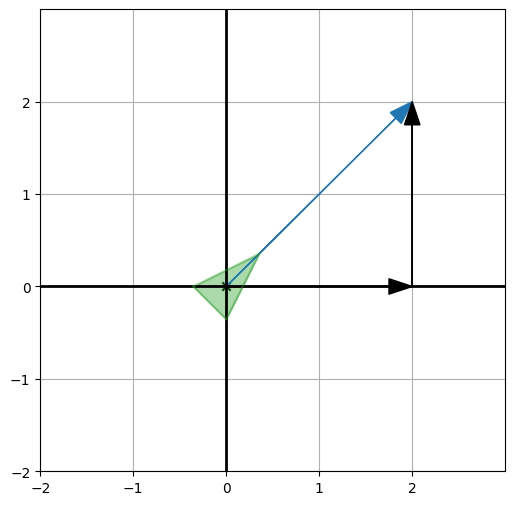

In [4]:
from math import pi
from vec2d.graph import draw, Polygon, Colors, Arrow
from vec2d.math import rotate


ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]


draw(
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN),
    Arrow((2, 2), color=Colors.BLUE),
    Arrow((2, 0), color=Colors.BLACK),
    Arrow((2, 2), (2, 0), color=Colors.BLACK),
)

The picture above illustrates the problem. We need to find the components of the blue vector.

But if we annotate the picture for better clarity:

![Acceleration components](pics/acceleration_components.png)

We know that:

$
\displaystyle
cos(\theta) = \frac{a_x}{|\vec{a}|} \\~\\
sin(\theta) = \frac{a_y}{|\vec{a}|}
$

And therefore:

$
\displaystyle
a_x = |\vec{a}| \cdot cos(\theta) \\
a_y = |\vec{a}| \cdot sin(\theta)
$

Thus, in each iteration of the game loop, we need to update the velocity of the ship before it moves. 

Because the acceleration is constant, over an elapsed time $ \Delta t $, the update to the velocity components will be:

$
v_x = a_x \cdot \Delta t \\
v_x = a_y \cdot \Delta t \\
$

Thus, the changes in the game engine will be:

```python
...
ACCELERATION = 3
...
    while not done:
        # get elapsed milliseconds since last frame
        milliseconds = clock.tick()

    ...
        ship.move(milliseconds)
        draw_poly(screen, ship)
        for asteroid in asteroids:
            asteroid.move(milliseconds)
            draw_poly(screen, asteroid)

   ...
        if keys[pygame.K_UP]:
            ax = ACCELERATION * cos(ship.rotation_angle)
            ay = ACCELERATION * sin(ship.rotation_angle)
            ship.vx += ax * milliseconds / 1000
            ship.vy += ay * milliseconds / 1000

        for asteroid in asteroids:
            if asteroid.does_collide(ship):
                done = True

        # Update the screen
        pygame.display.flip()

    pygame.display.quit()
    pygame.quit()
    sys.exit(0)
```

With the added code, the spaceship now accelerates when the user presses the up arrow.

The movement of the ship has been a slightly more advanced application of Euler's method, where we have second derivatives to identify the ship's position:

$
x''(t) = v_x'(t) = a_x \\
y''(t) = v_y'(t) = a_y \\
$

At each step, we first update the velocities, and then we use the updated velocities in the `PolygonModel.move()` method to determine the updated positions.

## Digging deeper into Euler's method

The core idea of Euler's method is to start with an initial value of a quantity (like position) and an equation describing its derivatives (like velocity and acceleration), and then use the derivatives to update the quantity.

Let's see this in detail with an example.

Let an object start at time $ t = 0 $ at position $ (0, 0) $ with an initial velocity $ (1, 0) $ and a constant acceleration $ (0, 0.2) $.

This means that the object starts moving directly to the right, but it will go upward over time.

Our task is to find the values of the position vector every two seconds from $ t = 0 $ to $ t = 10 $ using Euler's method.

We'll find the solution by hand first to develop some intuition, and then we'll automate the process in Python. Once we have the positions, we'll be able to picture them in the 2D plane.

### Carrying out Euler's method by hand

Let's think that position, velocity, and acceleration are functions of time: $ \vec{s}(t) $, $ \vec{v}(t) $, and $ \vec{a}(t) $. 

We will assume that we're in the 2D plane, so that:

$
\vec{s}(t) = (x(t), y(t)) \\
\vec{v}(t) = (x'(t), y'(t)) \\
\vec{a}(t) = (x''(t), y''(t)) \\
$

We can start by laying out a table, in which we will start calculating the functions at certain $ t $ values.

Starting with $ t = 0 $, and using the initial values given at the end of the previous section:

| t   | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $ |
| --- | -------------- | -------------- | -------------- |
| 0 | (0, 0) | (1, 0) | (0, 0.2) |

Our goal is to find the position of the object every two seconds, from $ t = 0 $ to $ t = 10 $.

Thus, we need to end up populating the table for those instants:

| t   | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $ |
| --- | -------------- | -------------- | -------------- |
| 0 | (0, 0) | (1, 0) | (0, 0.2) |
| 2 |  |  |  |
| 4 |  |  |  |
| 6 |  |  |  |
| 8 |  |  |  |
| 10 |  |  |  |

As we said that the acceleration will be constant, we can already fill that column:

| t   | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $ |
| --- | -------------- | -------------- | -------------- |
| 0 | (0, 0) | (1, 0) | (0, 0.2) |
| 2 |  |  | (0, 0.2) |
| 4 |  |  | (0, 0.2) |
| 6 |  |  | (0, 0.2) |
| 8 |  |  | (0, 0.2) |
| 10 |  |  | (0, 0.2) |

Let's begin by thinking what happens in the 2-second period between $ t = 0 $ and $ t = 2 $?

The velocity can be obtained with the following pair of equations:

$
v_x(2) = v_x(0) + a_x(0) \cdot \Delta t = 1 + 0 \cdot 2 = 1 \\
v_y(2) = v_y(0) + a_y(0) \cdot \Delta t = 0 + 0.2 \cdot 2 = 0.4 \\
$

Similarly, with the $ \vec{v} $ calculated, we can find the position with the following pair of equations:

$
x(2) = x(0) + v_x(0) \cdot \Delta t = 0 + 1 \cdot 2 = 2 \\
y(2) = y(0) + v_y(0) \cdot \Delta t = 0 + 0 \cdot 2 = 0 \\
$

Which let us fill out the $ 2^{nd} $ row of the table:

| t   | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $ |
| --- | -------------- | -------------- | -------------- |
| 0 | (0, 0) | (1, 0) | (0, 0.2) |
| 2 |  (2, 0) | (1, 0.4) | (0, 0.2) |
| 4 |  |  | (0, 0.2) |
| 6 |  |  | (0, 0.2) |
| 8 |  |  | (0, 0.2) |
| 10 |  |  | (0, 0.2) |

In the same way, we can start calculating what happens between $ t = 2 $ and $ t = 4 $:

$
\vec{v}(4) = \vec{v}(2) + \vec{a}(2) \cdot \Delta t \\
= (1, 0.4) + (0, 0.2) \cdot 2 = (1, 0.8)
$

The position will increase according to the velocity at $ t = 2 $:

$
\vec{s}(4) = \vec{s}(2) + \vec{v}(2) \cdot \Delta t \\
= (2, 0) + (1, 0.4) \cdot 2 = (4, 0.8) 
$

Note that the difference in the position can be written as:

$
\Delta \vec{s} = \vec{v}(2) \cdot \Delta t = (1, 0.4) \cdot 2 = (2, 0.8)
$

That is:

$
\vec{s}(4) = \vec{s}(2) + \Delta \vec{s}
$

Now we can populate the $ 3^{rd} $ row:

| t   | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $ |
| --- | -------------- | -------------- | -------------- |
| 0 | (0, 0) | (1, 0) | (0, 0.2) |
| 2 | (2, 0) | (1, 0.4) | (0, 0.2) |
| 4 | (4, 0.8)  | (1, 0.8) | (0, 0.2) |
| 6 |  |  | (0, 0.2) |
| 8 |  |  | (0, 0.2) |
| 10 |  |  | (0, 0.2) |

And we could go on and on until we have the full table populated, but it is time consuming and error-prone when doing it manually, so let's start using Python for that.

Another thing to take into account is that we're taking approximations. That is, it isn't quite correct to write $ \Delta \vec{s} = \vec{v} \cdot \Delta t $.

### Implementing the algorithm in Python

Describing the manual procedure carried out in the previous section using Python does not seem too complicated.

In essence, you just need to set up the initial values and run a for loop:

In [12]:
from vec2d.math import add, scale
from tabulate import tabulate

t = 0
s = (0, 0)
v = (1, 0)
a = (0, 0.2)

dt = 2
steps = 5

times = [t]
positions = [s]
velocities = [v]
accelerations = [a]
for _ in range(steps):
    t += 2
    s = add(s, scale(dt, v))
    v = add(v, scale(dt, a))

    times.append(t)
    positions.append(s)
    velocities.append(v)
    accelerations.append(a)


print(tabulate([[t, s, v, a] for t, s, v, a in zip(times, positions, velocities, accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"], floatfmt=".2f"))

  t  s(t)                     v(t)                     a(t)
---  -----------------------  -----------------------  --------
  0  (0, 0)                   (1, 0)                   (0, 0.2)
  2  (2, 0)                   (1, 0.4)                 (0, 0.2)
  4  (4, 0.8)                 (1, 0.8)                 (0, 0.2)
  6  (6, 2.4000000000000004)  (1, 1.2000000000000002)  (0, 0.2)
  8  (8, 4.800000000000001)   (1, 1.6)                 (0, 0.2)
 10  (10, 8.0)                (1, 2.0)                 (0, 0.2)


With the table in place, we can decide to also plot the results to interpret the trajectory of the object geometrically:

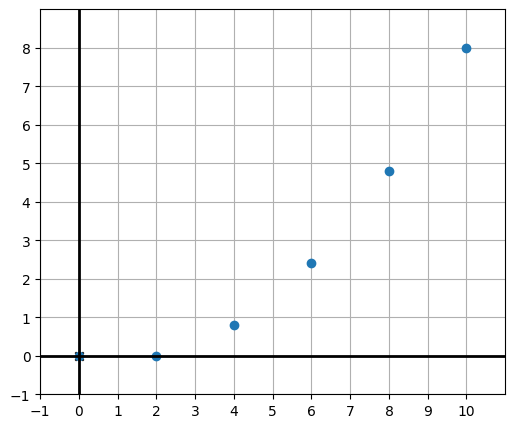

In [14]:
from vec2d.graph import draw, Points, Colors

from vec2d.math import add, scale
from tabulate import tabulate

t = 0
s = (0, 0)
v = (1, 0)
a = (0, 0.2)

dt = 2
steps = 5

times = [t]
positions = [s]
velocities = [v]
accelerations = [a]
for _ in range(steps):
    t += 2
    s = add(s, scale(dt, v))
    v = add(v, scale(dt, a))

    times.append(t)
    positions.append(s)
    velocities.append(v)
    accelerations.append(a)

draw(
    Points(*positions, color=Colors.BLUE),
)

Because we are using approximations, we don't know the trajectory between the plotted points &mdash; it's as if the object moved in five straight lines at a different velocity on each of the five time intervals:

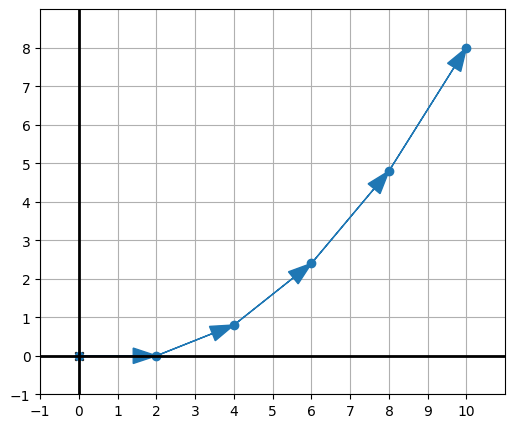

In [2]:
from vec2d.graph import draw, Points, Arrow, Colors
from vec2d.math import add, scale

t = 0
s = (0, 0)
v = (1, 0)
a = (0, 0.2)

dt = 2
steps = 5

times = [t]
positions = [s]
velocities = [v]
accelerations = [a]
for _ in range(steps):
    t += dt
    s = add(s, scale(dt, v))
    v = add(v, scale(dt, a))

    times.append(t)
    positions.append(s)
    velocities.append(v)
    accelerations.append(a)



displacement_vectors = [Arrow(s_, s, color=Colors.BLUE) for s, s_ in zip(positions, positions[1:])]
draw(
    Points(*positions, color=Colors.BLUE),
    *displacement_vectors
)

We know it's an approximation because the object is supposed to be accelerating the whole time, so the expectation is for the trajectory to be a smooth curve rather than these straight lines.

## Running Euler's method with smaller steps

Now that we have Euler's method implemented in Python, it's easy to rerun the same scenario with different parameters to evaluate the quality of the approximation.

Let's start by reducing the delta time so that `dt=1` while increasing the number of points so that `steps=10`.

We will be simulating the same scenario, with the same approach, only that we will have more data points:

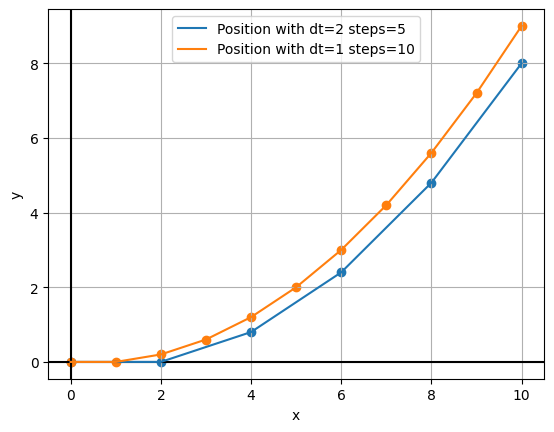

In [3]:
from collections import namedtuple
import matplotlib.pyplot as plt
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=2,
    steps=5
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=2 steps=5")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=1,
    steps=10
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=1 steps=10")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

ax.legend()
plt.show()

We see that Euler's method produces different results given the same initial values and different number of steps.

If we try again with 100 steps, we get yet another trajectory:

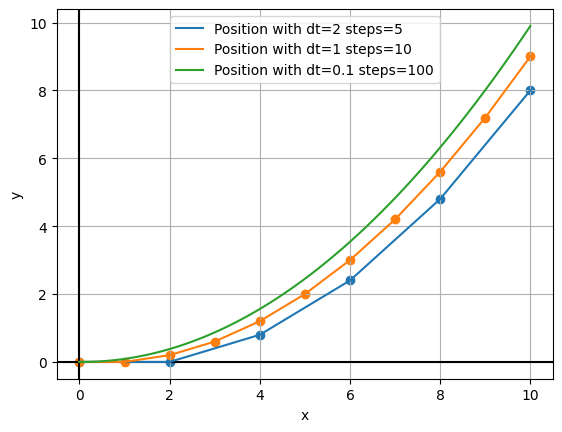

In [7]:
from collections import namedtuple
import matplotlib.pyplot as plt
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=2,
    steps=5
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=2 steps=5")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=1,
    steps=10
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=1 steps=10")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=0.1,
    steps=100
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.1 steps=100")

ax.legend()
plt.show()

See how the graph becomes smoother but we get different results even if the same equations went into all three calculations.

It seems that the more time steps we use, the bigger y-coordinates we get.

We can see the problem if we zoom in at the the first two seconds.

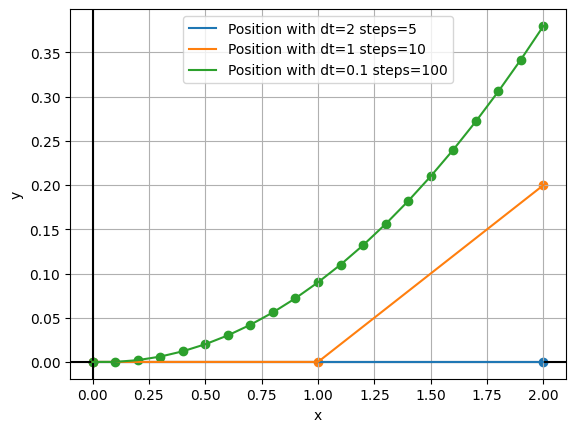

In [9]:
from collections import namedtuple
import matplotlib.pyplot as plt
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=2,
    steps=1
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=2 steps=5")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=1,
    steps=2
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=1 steps=10")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=0.1,
    steps=20
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.1 steps=100")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

ax.legend()
plt.show()

In the graph with `steps=5`, there's no acceleration considered, and therefore, the object moves along the x-axis with the initial velocity.

However, in the `steps=10` scenario, the object had one chance to update its velocity, and therefore, it has risen above the x-axis.

This becomes more evident with `steps=100` because there are 19 velocity updates between `t=0` and `t=2`

Therefore, we can say that the equation:

$
\Delta \vec{s} = \vec{v} \cdot \Delta t
$

is only correct when the velocity is constant, in other scenarios is just an approximation that gets better as the number of steps increases and the time intervals decrease, because the velocity won't change that much.

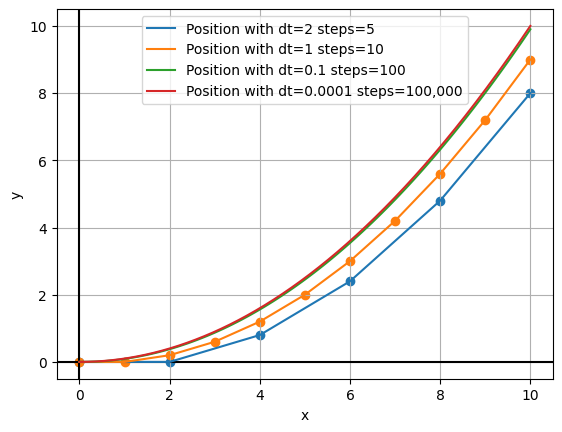

In [10]:
from collections import namedtuple
import matplotlib.pyplot as plt
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=2,
    steps=5
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=2 steps=5")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=1,
    steps=10
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=1 steps=10")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=0.1,
    steps=100
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.1 steps=100")

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=0.0001,
    steps=100000
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.0001 steps=100,000")


ax.legend()
plt.show()

See how the difference in the trajectory begins to converge.

In particular, the final position is $ (10.0, 10.0) $ (calculated using integrals as we will see in a subsequent chapter) and in our latest calculation we get: 

In [11]:
from collections import namedtuple
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)



kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=0.0001,
    steps=100000
)

print(kinematics.positions[-1])



(9.999999999990033, 9.999899999993497)


Which is a very good approximation of the exact position $ (10, 10) $.

### Exercises

Create a function that carries out Euler's method automatically for a constantly accelerating object. You need to provide the function with an acceleration vector, initial velocity vector, initial position vector, and perhaps other parameters.

We already created such function in the concepts section, so in this exercise we'll refactor it a little bit to make it more usable.

The one we defined was:

In [1]:
from collections import namedtuple
from vec2d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics(t0, s0, v0, a0, dt, steps):
    t = t0
    s = s0
    v = v0
    a = a0

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    dt=1,
    steps=10
)

print(
    tabulate([[t, s, v, a] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])
)

  t  s(t)                     v(t)                     a(t)
---  -----------------------  -----------------------  --------
  0  (0, 0)                   (1, 0)                   (0, 0.2)
  1  (1, 0)                   (1, 0.2)                 (0, 0.2)
  2  (2, 0.2)                 (1, 0.4)                 (0, 0.2)
  3  (3, 0.6000000000000001)  (1, 0.6000000000000001)  (0, 0.2)
  4  (4, 1.2000000000000002)  (1, 0.8)                 (0, 0.2)
  5  (5, 2.0)                 (1, 1.0)                 (0, 0.2)
  6  (6, 3.0)                 (1, 1.2)                 (0, 0.2)
  7  (7, 4.2)                 (1, 1.4)                 (0, 0.2)
  8  (8, 5.6)                 (1, 1.5999999999999999)  (0, 0.2)
  9  (9, 7.199999999999999)   (1, 1.7999999999999998)  (0, 0.2)
 10  (10, 9.0)                (1, 1.9999999999999998)  (0, 0.2)


The thing I dislike the most, is the having to give both the `dt` and the number of `steps`. It will feel more natural to give the end time and either the number of steps, or the dt:

In [4]:
from collections import namedtuple
from vec2d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=2,
    steps=5
)

print(
    tabulate([[t, s, v, a] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])
)

  t  s(t)                                       v(t)                        a(t)
---  -----------------------------------------  --------------------------  --------
0    (0, 0)                                     (1, 0)                      (0, 0.2)
0.4  (0.4, 0.0)                                 (1.0, 0.08000000000000002)  (0, 0.2)
0.8  (0.8, 0.03200000000000001)                 (1.0, 0.16000000000000003)  (0, 0.2)
1.2  (1.2000000000000002, 0.09600000000000003)  (1.0, 0.24000000000000005)  (0, 0.2)
1.6  (1.6, 0.19200000000000006)                 (1.0, 0.32000000000000006)  (0, 0.2)
2    (2.0, 0.32000000000000006)                 (1.0, 0.4000000000000001)   (0, 0.2)


Another possible optimization is 

In [20]:
from collections import namedtuple
from vec2d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=2,
    steps=5
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

  t  s(t)         v(t)         a(t)
---  -----------  -----------  --------
0    (0, 0)       (1, 0)       (0, 0.2)
0.4  (0.4, 0.0)   (1.0, 0.08)  (0, 0.2)
0.8  (0.8, 0.03)  (1.0, 0.16)  (0, 0.2)
1.2  (1.2, 0.1)   (1.0, 0.24)  (0, 0.2)
1.6  (1.6, 0.19)  (1.0, 0.32)  (0, 0.2)
2    (2.0, 0.32)  (1.0, 0.4)   (0, 0.2)


### Exercise

In the calculation of the section [Running Euler's method with smaller steps](#running-eulers-method-with-smaller-steps) we under approximated the y-coordinate position, because we updated the y component of the velocity at the end of each time interval. Update the velocity at the beginning of each time interval and show that you over approximate the y position over time.

Let's try to understand what the exercise is telling us first.

The calculation that we're doing is:

```python
  t = t0
  s = s0
  v = v0
  a = a0
  dt = (t_end - t0) / steps

  times = [t]
  positions = [s]
  velocities = [v]
  accelerations = [a]
  for _ in range(steps):
      t += dt
      s = add(s, scale(dt, v))
      v = add(v, scale(dt, a))

      times.append(t)
      positions.append(s)
      velocities.append(v)
      accelerations.append(a)
```

We see that the velocity is updated with the previous value of v. What the exercise is telling us is that if we updated v before s, we would get over approximation. That is, the expectation is that as the number of steps grow, we will also converge to $ (10, 10) $ but with from above rather than from below.

Let's see it first with a simple table:

In [23]:
from collections import namedtuple
from vec2d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler_over(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        v = add(v, scale(dt, a))
        s = add(s, scale(dt, v))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=5
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

  t  s(t)          v(t)        a(t)
---  ------------  ----------  --------
  0  (0, 0)        (1, 0)      (0, 0.2)
  2  (2.0, 0.8)    (1.0, 0.4)  (0, 0.2)
  4  (4.0, 2.4)    (1.0, 0.8)  (0, 0.2)
  6  (6.0, 4.8)    (1.0, 1.2)  (0, 0.2)
  8  (8.0, 8.0)    (1.0, 1.6)  (0, 0.2)
 10  (10.0, 12.0)  (1.0, 2.0)  (0, 0.2)


See how with five steps, the final y-coordinate is 12.0, which is above 10.0 (the exact final position found when using integrals).

If we increase the number of steps, we should get a value that is closer to the real 10.0 value.

In [24]:
from collections import namedtuple
from vec2d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler_over(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        v = add(v, scale(dt, a))
        s = add(s, scale(dt, v))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=10
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

  t  s(t)          v(t)        a(t)
---  ------------  ----------  --------
  0  (0, 0)        (1, 0)      (0, 0.2)
  1  (1.0, 0.2)    (1.0, 0.2)  (0, 0.2)
  2  (2.0, 0.6)    (1.0, 0.4)  (0, 0.2)
  3  (3.0, 1.2)    (1.0, 0.6)  (0, 0.2)
  4  (4.0, 2.0)    (1.0, 0.8)  (0, 0.2)
  5  (5.0, 3.0)    (1.0, 1.0)  (0, 0.2)
  6  (6.0, 4.2)    (1.0, 1.2)  (0, 0.2)
  7  (7.0, 5.6)    (1.0, 1.4)  (0, 0.2)
  8  (8.0, 7.2)    (1.0, 1.6)  (0, 0.2)
  9  (9.0, 9.0)    (1.0, 1.8)  (0, 0.2)
 10  (10.0, 11.0)  (1.0, 2.0)  (0, 0.2)


We can finally plot it to validate:

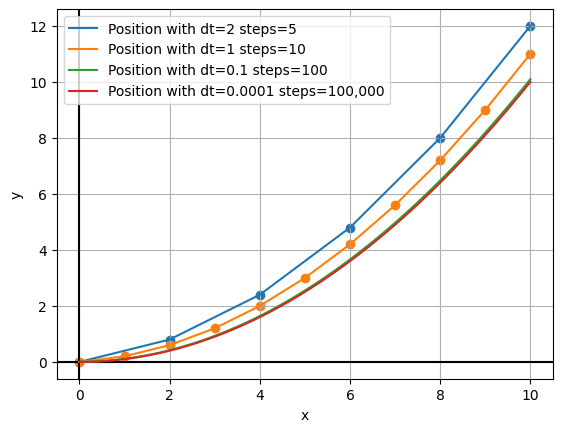

In [25]:
from collections import namedtuple
import matplotlib.pyplot as plt
from vec2d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler_over(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        v = add(v, scale(dt, a))
        s = add(s, scale(dt, v))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=5
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=2 steps=5")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=10
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=1 steps=10")
ax.scatter([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions])

kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=100
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.1 steps=100")

kinematics = get_kinematics_euler_over(
    t0=0,
    s0=(0, 0),
    v0=(1, 0),
    a0=(0, 0.2),
    t_end=10,
    steps=100000
)
ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="Position with dt=0.0001 steps=100,000")


ax.legend()
plt.show()

We see how as the number of steps increases, we get closer and closer to the real position.

### Exercise

Any projectile like a thrown baseball, a bullet, or an airborne snowboarder experiences the same acceleration vector 9.81 m/s/s towards the earth.

If we think of the x-axis of the plane as flat ground with the positive y-axis pointing upwards, that amounts to an acceleration of $ (0, 9.81) $.

If a baseball is thrown from shoulder height we could say its initial position would be $ (0, 1.5) $. If we assume it's thrown at an initial speed of 30 m/s at an angle of 20° up from the positive x direction, simulate the trajectory with Euler's method.

Approximately, how far does the baseball go in the x direction before hitting the ground?

We can use Euler's method to calculate the trajectory and then tabulate and plot the results.

The novel details is that the ball is thrown with a speed of 30 m/s at a certain angle. We will need to use trigonometry to get the velocity coordinates:

$$
tan(angle) = \frac{vertical}{horizontal}
$$

$$
sin(angle) = \frac{vertical}{distance}
$$

$$
cos(angle) = \frac{horizontal}{distance}
$$

![Polar to Cartesian](../01_linear-algebra-2d/pics/polar-to-cartesian-formula.png)

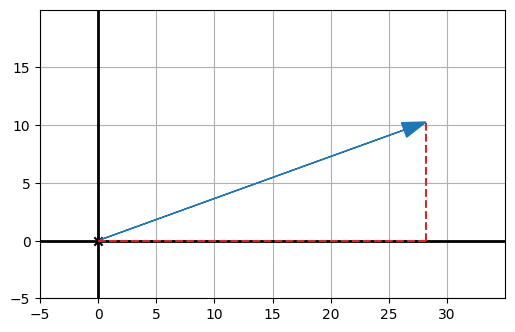

In [29]:
from vec2d.graph import draw, Arrow, Segment, Colors, LineStyles
from vec2d.math import to_polar, to_cartesian, to_radians
from math import sin, cos

v = to_cartesian((30, to_radians(20)))
v_y = 30 * sin(to_radians(20))
v_x = 30 * cos(to_radians(20))

draw(
    Arrow(v, color=Colors.BLUE),
    Segment((0, 0), (v_x, 0), color=Colors.RED, linestyle=LineStyles.DASHED),
    Segment((v_x, 0), (v_x, v_y), color=Colors.RED, linestyle=LineStyles.DASHED),
    grid=(5, 5)
)


And annotated for better clarity:

![Velocity components when angle is given](pics/velocity_components_angle.png)

With this legwork done, we can calculate the trajectory using our Euler's approximation:

In [34]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=3,
    steps=10
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

  t  s(t)            v(t)             a(t)
---  --------------  ---------------  ----------
0    (0, 1.5)        (28.19, 10.26)   (0, -9.81)
0.3  (8.46, 4.58)    (28.19, 7.32)    (0, -9.81)
0.6  (16.91, 6.77)   (28.19, 4.37)    (0, -9.81)
0.9  (25.37, 8.09)   (28.19, 1.43)    (0, -9.81)
1.2  (33.83, 8.52)   (28.19, -1.51)   (0, -9.81)
1.5  (42.29, 8.06)   (28.19, -4.45)   (0, -9.81)
1.8  (50.74, 6.73)   (28.19, -7.4)    (0, -9.81)
2.1  (59.2, 4.51)    (28.19, -10.34)  (0, -9.81)
2.4  (67.66, 1.4)    (28.19, -13.28)  (0, -9.81)
2.7  (76.12, -2.58)  (28.19, -16.23)  (0, -9.81)
3    (84.57, -7.45)  (28.19, -19.17)  (0, -9.81)


So we see that the ball starts going up for a while, but then gravity kicks in and brings the ball to the ground between the second 2.4 and 2.7.

Let's plot it:

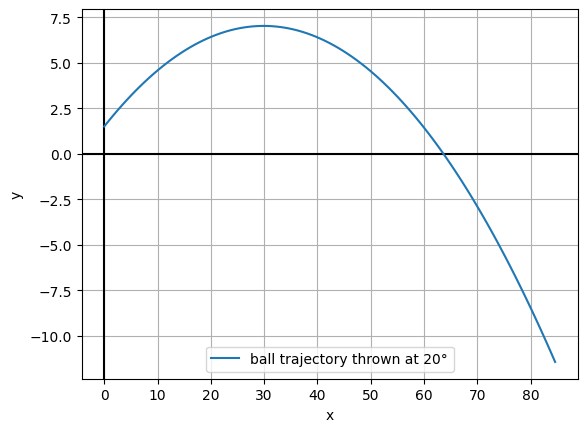

In [40]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
import matplotlib.pyplot as plt


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=3,
    steps=100
)


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(range(0, 100, 10))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")


ax.plot([x for x, _ in kinematics.positions], [y for _, y in kinematics.positions], label="ball trajectory thrown at 20°")

ax.legend()
plt.show()



We can use the table to find an approximation for when the ball hits the ground:

In [43]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

angle = 20 * pi / 180

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=2.28,
    steps=100
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

     t  s(t)            v(t)             a(t)
------  --------------  ---------------  ----------
0       (0, 1.5)        (28.19, 10.26)   (0, -9.81)
0.0228  (0.64, 1.73)    (28.19, 10.04)   (0, -9.81)
0.0456  (1.29, 1.96)    (28.19, 9.81)    (0, -9.81)
0.0684  (1.93, 2.19)    (28.19, 9.59)    (0, -9.81)
0.0912  (2.57, 2.41)    (28.19, 9.37)    (0, -9.81)
0.114   (3.21, 2.62)    (28.19, 9.14)    (0, -9.81)
0.1368  (3.86, 2.83)    (28.19, 8.92)    (0, -9.81)
0.1596  (4.5, 3.03)     (28.19, 8.69)    (0, -9.81)
0.1824  (5.14, 3.23)    (28.19, 8.47)    (0, -9.81)
0.2052  (5.78, 3.42)    (28.19, 8.25)    (0, -9.81)
0.228   (6.43, 3.61)    (28.19, 8.02)    (0, -9.81)
0.2508  (7.07, 3.79)    (28.19, 7.8)     (0, -9.81)
0.2736  (7.71, 3.97)    (28.19, 7.58)    (0, -9.81)
0.2964  (8.36, 4.14)    (28.19, 7.35)    (0, -9.81)
0.3192  (9.0, 4.31)     (28.19, 7.13)    (0, -9.81)
0.342   (9.64, 4.47)    (28.19, 6.91)    (0, -9.81)
0.3648  (10.28, 4.63)   (28.19, 6.68)    (0, -9.81)
0.3876  (10.93, 4.

So it seems that around t = 2.25 the ball hits the ground when x is about 63 m.

### Exercise

Rerun the Euler's method simulation from the previous exercise with the same initial speed of 30 m/s but using an initial position of (0, 0) and trying various angles for the initial velocity. What angle makes the baseball go the farthest before hitting the ground?

We just need to adjust the simulation to try with different angles:

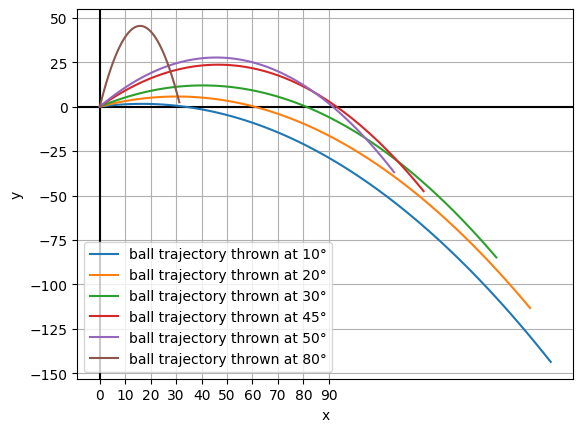

In [48]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
import matplotlib.pyplot as plt


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=3,
    steps=100
)

def baseball_trajectory(angle):
    kinematics = get_kinematics_euler(
        t0=0,
        s0=(0, 0),
        v0=(30 * cos(to_radians(angle)), 30 * sin(to_radians(angle))),
        a0=(0, -9.81),
        t_end=6,
        steps=100
    )

    return kinematics.positions


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(range(0, 100, 10))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

for angle in [10, 20, 30, 45, 50, 80]:
    ax.plot([x for x, _ in baseball_trajectory(angle)], [y for _, y in baseball_trajectory(angle)], label=f"ball trajectory thrown at {angle}°")

ax.legend()
plt.show()



Thus, throwing the ball at a 45° angle seems to be the optimum.

We can adjust the plot to make it prettier:

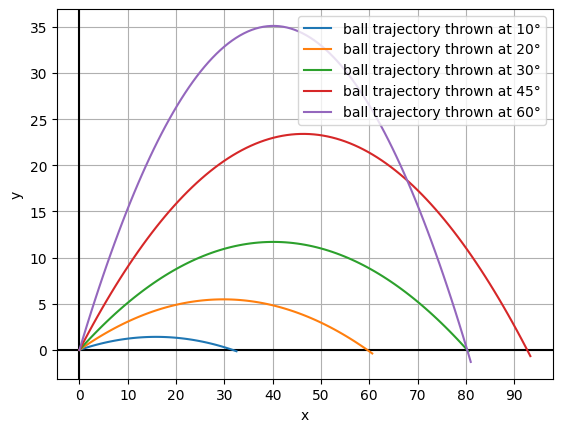

In [67]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
import matplotlib.pyplot as plt


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=3,
    steps=100
)

def baseball_trajectory(angle, t_end):
    kinematics = get_kinematics_euler(
        t0=0,
        s0=(0, 0),
        v0=(30 * cos(to_radians(angle)), 30 * sin(to_radians(angle))),
        a0=(0, -9.81),
        t_end=t_end,
        steps=100
    )

    return kinematics.positions


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(range(0, 100, 10))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

for angle, t_end in [(10, 1.1), (20, 2.15), (30, 3.1), (45, 4.4), (60, 5.4) ]:
    ax.plot([x for x, _ in baseball_trajectory(angle, t_end)], [y for _, y in baseball_trajectory(angle, t_end)], label=f"ball trajectory thrown at {angle}°")

ax.legend()
plt.show()



So definitely, 45° seems to be the angle that maximizes how far the ball goes before hitting the ground.

We can also fine-tune around the 45° mark:

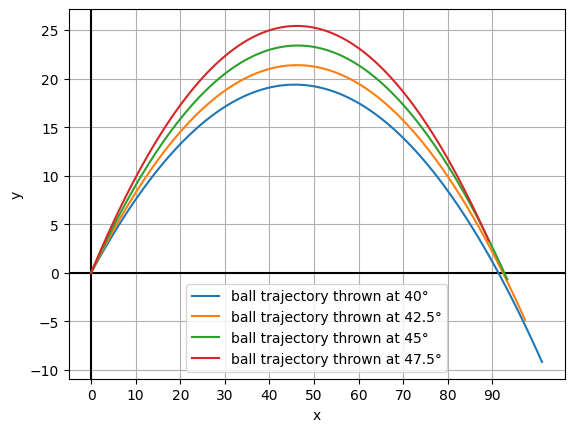

In [68]:
from collections import namedtuple
from math import sin, cos
from vec2d.math import add, scale, to_radians
import matplotlib.pyplot as plt


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)

kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 1.5),
    v0=(30 * cos(to_radians(20)), 30 * sin(to_radians(20))),
    a0=(0, -9.81),
    t_end=3,
    steps=100
)

def baseball_trajectory(angle, t_end):
    kinematics = get_kinematics_euler(
        t0=0,
        s0=(0, 0),
        v0=(30 * cos(to_radians(angle)), 30 * sin(to_radians(angle))),
        a0=(0, -9.81),
        t_end=t_end,
        steps=100
    )

    return kinematics.positions


_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(range(0, 100, 10))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

for angle, t_end in [(40, 4.4), (42.5, 4.4), (45, 4.4), (47.5, 4.4) ]:
    ax.plot([x for x, _ in baseball_trajectory(angle, t_end)], [y for _, y in baseball_trajectory(angle, t_end)], label=f"ball trajectory thrown at {angle}°")

ax.legend()
plt.show()



### Exercise

An object moving in 3D space has an initial velocity of $ (1, 2, 0) $ and has a constant acceleration vector of $ (0, -1, 1) $.

If it starts at the origin, where is it after 10 seconds?
Plot its trajectory in 3D using the drawing functions from vec3d.

We've used Euler's method to calculate trajectories in 2D, but nothing prevents us from using it in 3D &mdash; we just need to switch the Maths backend.

Then, when invoking it, we just need to adjust the parameters using 3D vectors:

In [1]:
from collections import namedtuple
from vec3d.math import add, scale
from tabulate import tabulate


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 0, 0),
    v0=(1, 2, 0),
    a0=(0, -1, 1),
    t_end=10,
    steps=10
)

def pretty_table(kinematics, num_decimals=2, floatfmt=".2f"):
    def round_tuple(t):
        return tuple(round(x, num_decimals) for x in t)

    return tabulate([[t, round_tuple(s), round_tuple(v), round_tuple(a)] for t, s, v, a in zip(kinematics.times, kinematics.positions, kinematics.velocities, kinematics.accelerations)], headers=["t", "s(t)", "v(t)", "a(t)"])

print(
    pretty_table(kinematics)
)

  t  s(t)                 v(t)               a(t)
---  -------------------  -----------------  ----------
  0  (0, 0, 0)            (1, 2, 0)          (0, -1, 1)
  1  (1.0, 2.0, 0.0)      (1.0, 1.0, 1.0)    (0, -1, 1)
  2  (2.0, 3.0, 1.0)      (1.0, 0.0, 2.0)    (0, -1, 1)
  3  (3.0, 3.0, 3.0)      (1.0, -1.0, 3.0)   (0, -1, 1)
  4  (4.0, 2.0, 6.0)      (1.0, -2.0, 4.0)   (0, -1, 1)
  5  (5.0, 0.0, 10.0)     (1.0, -3.0, 5.0)   (0, -1, 1)
  6  (6.0, -3.0, 15.0)    (1.0, -4.0, 6.0)   (0, -1, 1)
  7  (7.0, -7.0, 21.0)    (1.0, -5.0, 7.0)   (0, -1, 1)
  8  (8.0, -12.0, 28.0)   (1.0, -6.0, 8.0)   (0, -1, 1)
  9  (9.0, -18.0, 36.0)   (1.0, -7.0, 9.0)   (0, -1, 1)
 10  (10.0, -25.0, 45.0)  (1.0, -8.0, 10.0)  (0, -1, 1)


Thus, after 10 seconds, the object will be in $ (10, -25, 45) $. That is consistent with the given acceleration and initial velocity.

Let's now plot it using `vec3d`:

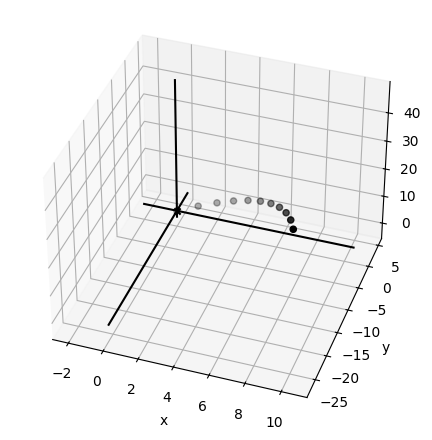

In [17]:
from collections import namedtuple
from vec3d.math import add, scale
from vec3d.graph import draw3d, Points3D, Box3D


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 0, 0),
    v0=(1, 2, 0),
    a0=(0, -1, 1),
    t_end=10,
    steps=10
)

draw3d(
    Points3D(*kinematics.positions),
    depthshade=True,
    width=15,
    elev=37,
    azim=-70

)

And the last position can be approximated increasing the number of points:

In [18]:
from collections import namedtuple
from vec3d.math import add, scale


Kinematics = namedtuple("Kinematics", "times, positions, velocities, accelerations")

def get_kinematics_euler(t0, s0, v0, a0, t_end, steps):
    t = t0
    s = s0
    v = v0
    a = a0
    dt = (t_end - t0) / steps

    times = [t]
    positions = [s]
    velocities = [v]
    accelerations = [a]
    for _ in range(steps):
        t += dt
        s = add(s, scale(dt, v))
        v = add(v, scale(dt, a))

        times.append(t)
        positions.append(s)
        velocities.append(v)
        accelerations.append(a)

    return Kinematics(times, positions, velocities, accelerations)


kinematics = get_kinematics_euler(
    t0=0,
    s0=(0, 0, 0),
    v0=(1, 2, 0),
    a0=(0, -1, 1),
    t_end=10,
    steps=100
)

print(kinematics.positions[-1])

(9.99999999999998, -29.499999999999993, 49.49999999999995)


Which means that the last position after 10 seconds will be approximately $ (10, -30, 50) $, which is the exact position that would be found using integrals.